# Importing the dependencies

In [1]:
!pip install opendatasets --quiet

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets.utils import download_url
import torchvision.transforms as T
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.datasets import MNIST


%matplotlib inline
# torch.manual_seed(42)

In [3]:
import opendatasets as od
import os

In [4]:
url = 'https://www.kaggle.com/cashutosh/gender-classification-dataset'
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: royalalbert
Your Kaggle Key: ··········


100%|██████████| 269M/269M [00:02<00:00, 141MB/s]


In [5]:
classes = ['Female','Male']
classes

['Female', 'Male']

# Creating the Dataloaders, performing image augmentation and channel normalization

In [6]:
image_size = 64
batch_size = 256
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [7]:
from PIL import Image

def open_image(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [8]:
# yo classification haina image lai augment garne. yesma jasto image ma train vaxa testai generate hune ho. so, augment gare testai type
# -image aauxa. So, dont augment the images

train_path = 'gender-classification-dataset/Training'

train_ds = ImageFolder(train_path, transform=T.Compose([
    T.Resize((image_size,image_size)),
    # T.RandomCrop(image_size),   
    # T.Pad(10, padding_mode = 'reflect'),
    # T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)]))

In [9]:
len(train_ds)

47009

In [10]:
val_path  = 'gender-classification-dataset/Validation'

val_ds = ImageFolder(val_path, transform=T.Compose([
    T.Resize((image_size,image_size)),
    # T.RandomCrop(image_size),
    # T.Pad(10, padding_mode = 'reflect'),
    # T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*imagenet_stats)]))

In [11]:
len(val_ds)

11649

In [12]:
dataset = torch.utils.data.ConcatDataset([train_ds, val_ds])

In [13]:
len(dataset)

58658

In [14]:
val_ds.classes

['female', 'male']

In [15]:
img,tar = dataset[4005]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Female


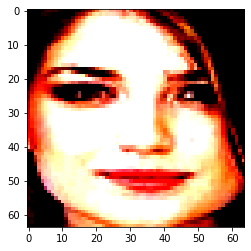

In [16]:
print(classes[tar])
plt.imshow(img.permute(1,2,0))

In [17]:
def denormalize_the_images(image, mean, std):
  if (len(image.shape) == 3):
    image = image.unsqueeze(0)
  mean = torch.tensor(mean).reshape(1,3,1,1) # image ta matrix tensor ma xa. so matrix multiply ra add garda shape eutai huna paryo nita
  std = torch.tensor(std).reshape(1,3,1,1)
  return image * std + mean

In [18]:
def displaying_image(img, label):
  print("Label is: ", label," or ",classes[label])
  denormalized_image_tensor = denormalize_the_images(img, *imagenet_stats)[0]
  plt.imshow(denormalized_image_tensor.permute(1,2,0))

In [19]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalize_the_images(images.detach()[:nmax], *imagenet_stats), nrow=8).permute(1, 2, 0))

# def show_batch(dl, nmax=64):
#     for images, _ in dl:
#         show_images(images, nmax)
#         break

In [20]:
dl = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([256, 3, 64, 64])


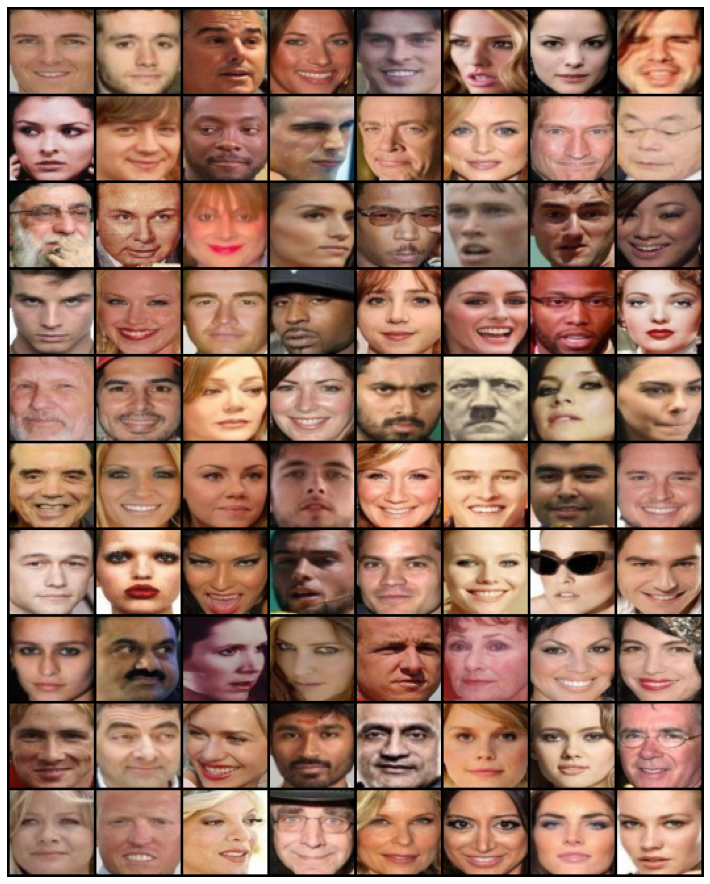

In [21]:
for images, _ in dl:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,16))
    plt.axis('off')
    images = denormalize_the_images(images[:80],*imagenet_stats)
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

# Creating Generator and Discriminator Models

In [22]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [23]:
latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    
    # nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(32),
    # nn.ReLU(True),
    # # out: 32 * 64 * 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(16),
    # nn.ReLU(True),
    # # out: 16 * 128 * 128

    # nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [24]:
xb = torch.randn(batch_size, latent_size, 1, 1) 
xb.shape

torch.Size([256, 128, 1, 1])

In [25]:
fake_images = generator(xb)
print(fake_images.shape)

torch.Size([256, 3, 64, 64])


In [26]:
fake_images.shape

torch.Size([256, 3, 64, 64])

In [27]:
# torchvision.transforms.Resize(84)(fake_images).shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


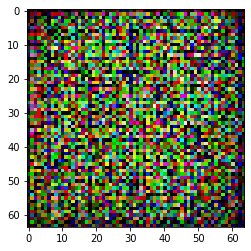

In [28]:
plt.imshow(fake_images[0].detach().permute(2,1,0))

In [29]:
# b = 256
# nz = 128
# noise = torch.ones(b, nz, 1, 1)
# conv = nn.ConvTranspose2d( nz, 3, kernel_size = 4, stride = 2, bias=False)

# noise1 = conv(noise);noise1.shape

# conv1 = nn.ConvTranspose2d(3, 3, kernel_size = 4, stride = 2, bias=False)

# noise2 = conv1(noise1);noise2.shape

In [30]:
# # getting first fake image
# imgf = fake_images[0]
# imgf.shape

In [31]:
# # resizing the image
# torchvision.transforms.Resize(84)(imgf).shape

In [32]:
# # adding additional dimension to the image
# imgf.unsqueeze(0).shape

# Using GPU

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

In [34]:
train_dl = DeviceDataLoader(dl,device)

In [35]:
discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

# Training our Model

In [36]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss =  F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # fake_images = torchvision.transforms.Resize(84)(fake_images)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss =  F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [37]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    # fake_images = torchvision.transforms.Resize(84)(fake_images)  
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss =  F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

# Setting Image Helper Functions

In [42]:
from torchvision.utils import save_image

In [43]:
sample_dir = 'Generated_Images'
os.makedirs(sample_dir, exist_ok=True)

In [44]:
import numpy as np
stats = torch.from_numpy(np.array([imagenet_stats]));stats
stats = stats.to(device='cuda')

In [45]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    # denormalize_the_images(images[:nmax],*stats)
    save_image(denormalize_the_images(fake_images, *stats[0]), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [46]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


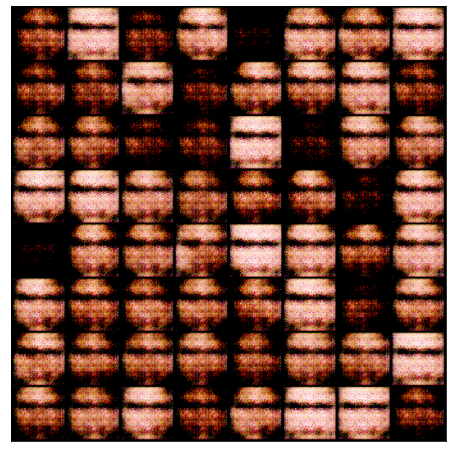

In [47]:
save_samples(0, fixed_latent)

# Full training loop

In [38]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [39]:
def fit(start_epoch,end_epoch, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(start_epoch, end_epoch):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, end_epoch, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [40]:
lr = 0.0002
start_epoch = 0
end_epoch = 20

In [48]:
history = fit(start_epoch,end_epoch, lr)

  0%|          | 0/230 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/20], loss_g: 3.6812, loss_d: 0.4399, real_score: 0.7594, fake_score: 0.0229
Saving generated-images-0001.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 5.8826, loss_d: 0.4927, real_score: 0.9175, fake_score: 0.3165
Saving generated-images-0002.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 3.0987, loss_d: 0.2216, real_score: 0.9217, fake_score: 0.1232
Saving generated-images-0003.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 5.2334, loss_d: 0.5118, real_score: 0.9759, fake_score: 0.3586
Saving generated-images-0004.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 4.2532, loss_d: 0.0394, real_score: 0.9728, fake_score: 0.0103
Saving generated-images-0005.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 3.9796, loss_d: 0.1664, real_score: 0.9872, fake_score: 0.1386
Saving generated-images-0006.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 3.7561, loss_d: 0.3090, real_score: 0.8668, fake_score: 0.1361
Saving generated-images-0007.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 3.7579, loss_d: 0.5137, real_score: 0.9848, fake_score: 0.3706
Saving generated-images-0008.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 7.0761, loss_d: 0.0092, real_score: 0.9921, fake_score: 0.0012
Saving generated-images-0009.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 5.6930, loss_d: 0.0216, real_score: 0.9813, fake_score: 0.0027
Saving generated-images-0010.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 4.7833, loss_d: 0.0223, real_score: 0.9971, fake_score: 0.0190
Saving generated-images-0011.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 3.7622, loss_d: 0.0850, real_score: 0.9938, fake_score: 0.0746
Saving generated-images-0012.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 4.4611, loss_d: 0.0252, real_score: 0.9893, fake_score: 0.0142
Saving generated-images-0013.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 7.7869, loss_d: 0.0012, real_score: 0.9993, fake_score: 0.0005
Saving generated-images-0014.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 5.4644, loss_d: 0.0198, real_score: 0.9891, fake_score: 0.0086
Saving generated-images-0015.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 6.2398, loss_d: 0.2546, real_score: 0.9945, fake_score: 0.2103
Saving generated-images-0016.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 9.8980, loss_d: 0.3948, real_score: 0.9405, fake_score: 0.2676
Saving generated-images-0017.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 4.2795, loss_d: 0.0657, real_score: 0.9980, fake_score: 0.0606
Saving generated-images-0018.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 6.7803, loss_d: 5.4212, real_score: 0.0071, fake_score: 0.0001
Saving generated-images-0019.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 9.7683, loss_d: 0.0009, real_score: 0.9991, fake_score: 0.0000
Saving generated-images-0020.png


In [49]:
history1 = fit(20,50, lr)

  0%|          | 0/230 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [21/50], loss_g: 6.7339, loss_d: 0.0289, real_score: 0.9731, fake_score: 0.0012
Saving generated-images-0021.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 8.3478, loss_d: 0.1461, real_score: 0.8703, fake_score: 0.0006
Saving generated-images-0022.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 7.5255, loss_d: 0.5905, real_score: 0.9732, fake_score: 0.3991
Saving generated-images-0023.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 6.3924, loss_d: 0.7089, real_score: 0.9998, fake_score: 0.4479
Saving generated-images-0024.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 3.9542, loss_d: 0.0661, real_score: 0.9735, fake_score: 0.0367
Saving generated-images-0025.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 6.1179, loss_d: 0.0198, real_score: 0.9836, fake_score: 0.0031
Saving generated-images-0026.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 11.6041, loss_d: 0.8558, real_score: 0.9897, fake_score: 0.5364
Saving generated-images-0027.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 11.1884, loss_d: 0.0028, real_score: 0.9972, fake_score: 0.0000
Saving generated-images-0028.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 9.6680, loss_d: 0.1531, real_score: 0.8680, fake_score: 0.0001
Saving generated-images-0029.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 6.1312, loss_d: 0.0172, real_score: 0.9871, fake_score: 0.0042
Saving generated-images-0030.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 5.1645, loss_d: 0.0175, real_score: 0.9913, fake_score: 0.0086
Saving generated-images-0031.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 6.5825, loss_d: 0.5683, real_score: 0.5929, fake_score: 0.0008
Saving generated-images-0032.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.0946, loss_d: 0.0285, real_score: 0.9983, fake_score: 0.0261
Saving generated-images-0033.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 5.8129, loss_d: 0.0925, real_score: 0.9775, fake_score: 0.0638
Saving generated-images-0034.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 5.1832, loss_d: 0.0238, real_score: 0.9815, fake_score: 0.0048
Saving generated-images-0035.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 5.2166, loss_d: 0.0091, real_score: 0.9991, fake_score: 0.0082
Saving generated-images-0036.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 2.9324, loss_d: 0.1887, real_score: 0.9232, fake_score: 0.0952
Saving generated-images-0037.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 7.7050, loss_d: 0.3261, real_score: 0.7438, fake_score: 0.0005
Saving generated-images-0038.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 3.9737, loss_d: 0.0460, real_score: 0.9827, fake_score: 0.0274
Saving generated-images-0039.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 6.1892, loss_d: 0.1239, real_score: 0.9933, fake_score: 0.1015
Saving generated-images-0040.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 7.9006, loss_d: 5.0481, real_score: 0.0098, fake_score: 0.0001
Saving generated-images-0041.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 7.7656, loss_d: 0.0129, real_score: 0.9889, fake_score: 0.0015
Saving generated-images-0042.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.7483, loss_d: 0.0576, real_score: 0.9911, fake_score: 0.0463
Saving generated-images-0043.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 5.1817, loss_d: 0.0542, real_score: 0.9523, fake_score: 0.0045
Saving generated-images-0044.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 6.0082, loss_d: 0.2224, real_score: 0.9740, fake_score: 0.1550
Saving generated-images-0045.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 6.4765, loss_d: 0.0222, real_score: 0.9804, fake_score: 0.0022
Saving generated-images-0046.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 9.7941, loss_d: 0.0217, real_score: 0.9796, fake_score: 0.0001
Saving generated-images-0047.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 8.2870, loss_d: 0.0153, real_score: 0.9868, fake_score: 0.0019
Saving generated-images-0048.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.9693, loss_d: 0.0602, real_score: 0.9842, fake_score: 0.0411
Saving generated-images-0049.png


  0%|          | 0/230 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 6.3115, loss_d: 0.0917, real_score: 0.9914, fake_score: 0.0762
Saving generated-images-0050.png


In [50]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Generator_weights_face_stage.pth')
torch.save(discriminator.state_dict(), 'Discriminator_weights_face_stage.pth')

In [53]:
!zip -r /content/Generated100.zip /content/Generated_Images

  adding: content/Generated_Images/ (stored 0%)
  adding: content/Generated_Images/generated-images-0016.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0038.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0010.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0050.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0029.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0039.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0041.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0009.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0047.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0044.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0012.png (deflated 0%)
  adding: content/Generated_Images/generated-images-0013.png (deflated 0%)
  adding: content/Generated_Images/generated-images-

In [54]:
from google.colab import files
files.download("/content/Generated100.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
from google.colab import files
files.download("/content/Generator_weights_face_stage.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
from google.colab import files
files.download("/content/Discriminator_weights_face_stage.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Thank you so much for visiting
# Please like, follow, and view my other projects